In [ ]:
# ==============================================================
# Lab 1: Identify and resolve lexical, syntactic, and semantic ambiguities in sentences using rule-based and statistical methods.
# ==============================================================

# Downloads for NLTK (fixes all LookupErrors)
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')

from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# ==============================================================
# 1. Lexical Ambiguity Resolution
# ==============================================================

STOP = set(stopwords.words('english'))

# --- Rule-based: Simplified Lesk Algorithm ---
def simple_lesk(target_word, sentence):
    sent_tokens = [w.lower() for w in nltk.word_tokenize(sentence)]
    best_sense = None
    max_overlap = 0
    for syn in wn.synsets(target_word):
        signature = ' '.join([syn.definition()] + syn.examples() + list(syn.lemma_names()))
        sig_tokens = [w.lower() for w in nltk.word_tokenize(signature)]
        sig_tokens = [w for w in sig_tokens if w.isalpha() and w not in STOP]
        overlap = sum((Counter(sig_tokens) & Counter(sent_tokens)).values())
        if overlap > max_overlap:
            max_overlap = overlap
            best_sense = syn
    return best_sense

# Example sentences
sent1 = "He went to the bank to deposit his paycheck."
sent2 = "They sat on the bank of the river to watch the sunset."

print("Lesk result 1:", simple_lesk("bank", sent1))
print("Lesk result 2:", simple_lesk("bank", sent2))


# --- Statistical: Naive Bayes for 'bank' senses ---
train_examples = [
    ("I deposited money at the bank", "finance"),
    ("She took a loan from the bank", "finance"),
    ("The bank closed early on Friday", "finance"),
    ("The river bank was full of wildflowers", "river"),
    ("He walked along the bank listening to the water", "river"),
    ("Cattle grazed on the bank after the rain", "river")
]

vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform([t for t, _ in train_examples])
y_train = [lbl for _, lbl in train_examples]

clf = MultinomialNB().fit(X_train, y_train)

def predict_bank_sense(sentence):
    x = vectorizer.transform([sentence])
    pred = clf.predict(x)[0]
    return pred, dict(zip(clf.classes_, clf.predict_proba(x)[0]))

print("NB prediction 1:", predict_bank_sense(sent1))
print("NB prediction 2:", predict_bank_sense(sent2))


# ==============================================================
# 2. Syntactic Ambiguity Resolution
# ==============================================================

from nltk import CFG, ChartParser, PCFG, ViterbiParser

# --- Rule-based: CFG with multiple parses ---
grammar = CFG.fromstring("""
S -> NP VP
NP -> 'I' | 'the' N | 'the' N PP
N -> 'man' | 'telescope'
VP -> V NP | VP PP
V -> 'saw'
PP -> P NP
P -> 'with'
""")

parser = ChartParser(grammar)
sentence = "I saw the man with the telescope".split()

print("\nAll parses (rule-based CFG):")
for tree in parser.parse(sentence):
    print(tree)
    tree.pretty_print()

# --- Statistical: PCFG selects most probable parse ---
pcfg = PCFG.fromstring("""
S -> NP VP [1.0]
NP -> 'I' [0.2] | Det N [0.4] | Det N PP [0.4]
VP -> V NP [0.6] | VP PP [0.4]
Det -> 'the' [1.0]
N -> 'man' [0.5] | 'telescope' [0.5]
V -> 'saw' [1.0]
PP -> P NP [1.0]
P -> 'with' [1.0]
""")

viterbi_parser = ViterbiParser(pcfg)

print("\nMost probable parse (PCFG):")
for tree in viterbi_parser.parse(sentence):
    print(tree)
    tree.pretty_print()
    break


# ==============================================================
# 3. Semantic Ambiguity Resolution
# ==============================================================

# --- Rule-based: POS heuristic ---
sent = "Visiting relatives can be annoying."
tokens = nltk.word_tokenize(sent)
pos = nltk.pos_tag(tokens, tagset='universal')  # use universal tagset
print("\nPOS tags:", pos)

def disambiguate_visiting(sentence):
    tokens = nltk.word_tokenize(sentence)
    pos = nltk.pos_tag(tokens, tagset='universal')
    if pos[0][1] == 'VERB' and pos[1][1] == 'NOUN':
        return "Gerund reading: 'Visiting relatives' = the act of visiting is annoying."
    else:
        return "Participle reading: 'Visiting relatives' = relatives who are visiting."

print(disambiguate_visiting(sent))


# --- Statistical: Cue-based similarity ---
cue_activity = {"visit", "going", "travel", "trip", "activity"}
cue_people = {"relative", "family", "friend", "guest", "visitor"}

def cue_disambiguate(sentence):
    words = set(w.lower() for w in nltk.word_tokenize(sentence) if w.isalpha())
    score_activity = len(words & cue_activity)
    score_people = len(words & cue_people)
    if score_activity > score_people:
        return "Activity sense (the action of visiting)."
    elif score_people > score_activity:
        return "People sense (relatives who are visiting)."
    else:
        return "Undecided by cues."

print("Cue method 1:", cue_disambiguate("Visiting relatives can be annoying."))
print("Cue method 2:", cue_disambiguate("Relatives visiting the city can be noisy."))


Lesk result 1: Synset('deposit.v.02')
Lesk result 2: Synset('bank.n.01')
NB prediction 1: (np.str_('finance'), {np.str_('finance'): np.float64(0.5094339622641509), np.str_('river'): np.float64(0.49056603773584906)})
NB prediction 2: (np.str_('river'), {np.str_('finance'): np.float64(0.3503123498318115), np.str_('river'): np.float64(0.6496876501681882)})

All parses (rule-based CFG):
(S
  (NP I)
  (VP
    (VP (V saw) (NP the (N man)))
    (PP (P with) (NP the (N telescope)))))
     S                                    
  ___|___________                          
 |               VP                       
 |        _______|________                 
 |       VP               PP              
 |    ___|___         ____|___             
 |   |       NP      |        NP          
 |   |    ___|___    |     ___|______      
 NP  V   |       N   P    |          N    
 |   |   |       |   |    |          |     
 I  saw the     man with the     telescope

(S
  (NP I)
  (VP (V saw) (NP the (N man

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [4]:
# Lab 2:Implement a basic NLP system with tokenization, POS tagging, and named entity recognition (NER).
#Install required packages before running:
# pip install nltk spacy transformers
# python -m spacy download en_core_web_sm

import nltk
import spacy
from nltk.tokenize import word_tokenize, sent_tokenize
from transformers import pipeline

# Download NLTK resources
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng") # Added this line to resolve the LookupError

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

text = "Google acquired DeepMind in London for $500 million."

# 1️⃣ Tokenization
tokens = word_tokenize(text)
print("Word Tokens:", tokens)

sent_tokens = sent_tokenize(text)
print("\nSentence Tokens:", sent_tokens)

# 2️⃣ POS Tagging
pos_tags = nltk.pos_tag(tokens)
print("\nPOS Tags:", pos_tags)

# 3️⃣ Named Entity Recognition using SpaCy
doc = nlp(text)
print("\nNER (SpaCy):")
for ent in doc.ents:
    print(ent.text, "->", ent.label_)

# 4️⃣ Named Entity Recognition using Transformer Model
ner_model = pipeline("ner", grouped_entities=True)
print("\nNER (Transformer):")
print(ner_model(text))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Word Tokens: ['Google', 'acquired', 'DeepMind', 'in', 'London', 'for', '$', '500', 'million', '.']

Sentence Tokens: ['Google acquired DeepMind in London for $500 million.']

POS Tags: [('Google', 'NNP'), ('acquired', 'VBD'), ('DeepMind', 'NNP'), ('in', 'IN'), ('London', 'NNP'), ('for', 'IN'), ('$', '$'), ('500', 'CD'), ('million', 'CD'), ('.', '.')]

NER (SpaCy):
Google -> ORG
DeepMind -> GPE
London -> GPE
$500 million -> MONEY


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/token_classification.py:186: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(



NER (Transformer):
[{'entity_group': 'ORG', 'score': np.float32(0.99947506), 'word': 'Google', 'start': 0, 'end': 6}, {'entity_group': 'ORG', 'score': np.float32(0.9989691), 'word': 'DeepMind', 'start': 16, 'end': 24}, {'entity_group': 'LOC', 'score': np.float32(0.99912757), 'word': 'London', 'start': 28, 'end': 34}]


In [5]:
# -----------------------------------------------------------
# AIM: Implement a morphological parser for English words(e.g., pluralization, verb conjugation) using FSTs
# -----------------------------------------------------------

# Import libraries
import re

# -----------------------------------------------------------
# 1. Irregular Lexicon (Exception Handling)
# -----------------------------------------------------------
IRREGULAR_NOUNS = {
    "child": "children",
    "mouse": "mice",
    "man": "men",
    "woman": "women",
    "person": "people",
    "foot": "feet",
    "tooth": "teeth",
    "goose": "geese",
}

IRREGULAR_VERBS_PAST = {
    "go": "went",
    "be": "was",
    "eat": "ate",
    "run": "ran",
    "come": "came",
    "have": "had",
    "make": "made",
    "see": "saw",
    "write": "wrote",
}

# -----------------------------------------------------------
# 2. Morphological Generators (Lexical → Surface)
# -----------------------------------------------------------

def pluralize(noun):
    """Generate plural form of English nouns."""
    if noun in IRREGULAR_NOUNS:
        return IRREGULAR_NOUNS[noun]
    if re.search(r"(s|x|z|ch|sh)$", noun):
        return noun + "es"             # e.g., box → boxes
    if re.search(r"[^aeiou]y$", noun):
        return noun[:-1] + "ies"       # e.g., city → cities
    return noun + "s"                  # default → add s


def past_tense(verb):
    """Generate past tense of verbs."""
    if verb in IRREGULAR_VERBS_PAST:
        return IRREGULAR_VERBS_PAST[verb]
    if verb.endswith("e"):
        return verb + "d"              # e.g., live → lived
    if re.search(r"[^aeiou]y$", verb):
        return verb[:-1] + "ied"       # e.g., try → tried
    if re.search(r"[aeiou][bcdfghjklmnpqrstvwxyz]$", verb):
        return verb + verb[-1] + "ed"  # e.g., stop → stopped
    return verb + "ed"                 # default rule


def present_participle(verb):
    """Generate present participle (-ing) form."""
    if verb.endswith("ie"):
        return verb[:-2] + "ying"      # e.g., lie → lying
    if verb.endswith("e") and not verb.endswith("ee"):
        return verb[:-1] + "ing"       # e.g., make → making
    if re.search(r"[aeiou][bcdfghjklmnpqrstvwxyz]$", verb):
        return verb + verb[-1] + "ing" # e.g., run → running
    return verb + "ing"                # default rule


# -----------------------------------------------------------
# 3. Morphological Analyzers (Surface → Lexical + Features)
# -----------------------------------------------------------

def analyze_plural(word):
    """Analyze plural nouns."""
    for base, plural in IRREGULAR_NOUNS.items():
        if word == plural:
            return f"{base}+N+PL"
    if re.search(r"ies$", word):
        return f"{word[:-3]}y+N+PL"
    if re.search(r"(es)$", word):
        return f"{word[:-2]}+N+PL"
    if word.endswith("s"):
        return f"{word[:-1]}+N+PL"
    return "UNKNOWN"


def analyze_past(word):
    """Analyze past tense verbs."""
    for base, past in IRREGULAR_VERBS_PAST.items():
        if word == past:
            return f"{base}+V+PAST"
    if re.search(r"ied$", word):
        return f"{word[:-3]}y+V+PAST"
    if re.search(r"([bcdfghjklmnpqrstvwxyz])\\1ed$", word):
        return f"{word[:-3]}+V+PAST"
    if word.endswith("ed"):
        return f"{word[:-2]}+V+PAST"
    return "UNKNOWN"


def analyze_ing(word):
    """Analyze present participle verbs."""
    if word.endswith("ying"):
        return f"{word[:-4]}ie+V+PROG"
    if re.search(r"([bcdfghjklmnpqrstvwxyz])\\1ing$", word):
        return f"{word[:-4]}+V+PROG"
    if word.endswith("ing"):
        return f"{word[:-3]}+V+PROG"
    return "UNKNOWN"


# -----------------------------------------------------------
# 4. High-Level Wrapper
# -----------------------------------------------------------

def generate(lemma, pos, feature):
    """Generate word form given lemma, POS, and morphological feature."""
    if pos == "N" and feature == "PL":
        return pluralize(lemma)
    if pos == "V" and feature == "PAST":
        return past_tense(lemma)
    if pos == "V" and feature == "PROG":
        return present_participle(lemma)
    return lemma


def analyze(word):
    """Return possible analyses for the word."""
    analyses = []
    plural = analyze_plural(word)
    if plural != "UNKNOWN":
        analyses.append(plural)
    past = analyze_past(word)
    if past != "UNKNOWN":
        analyses.append(past)
    ing = analyze_ing(word)
    if ing != "UNKNOWN":
        analyses.append(ing)
    return analyses or ["UNKNOWN"]


# -----------------------------------------------------------
# 5. Demonstration / Test
# -----------------------------------------------------------
if __name__ == "__main__":
    print("=== GENERATION (Lexical → Surface) ===")
    print("cat + N + PL  →", generate("cat", "N", "PL"))
    print("city + N + PL →", generate("city", "N", "PL"))
    print("try + V + PAST →", generate("try", "V", "PAST"))
    print("run + V + PROG →", generate("run", "V", "PROG"))
    print("go + V + PAST →", generate("go", "V", "PAST"))
    print("make + V + PROG →", generate("make", "V", "PROG"))

    print("\n=== ANALYSIS (Surface → Lexical + Features) ===")
    words = ["cats", "cities", "stopped", "running", "making", "went", "children"]
    for w in words:
        print(f"{w:10} → {analyze(w)}")


=== GENERATION (Lexical → Surface) ===
cat + N + PL  → cats
city + N + PL → cities
try + V + PAST → tried
run + V + PROG → running
go + V + PAST → went
make + V + PROG → making

=== ANALYSIS (Surface → Lexical + Features) ===
cats       → ['cat+N+PL']
cities     → ['city+N+PL']
stopped    → ['stopp+V+PAST']
running    → ['runn+V+PROG']
making     → ['mak+V+PROG']
went       → ['go+V+PAST']
children   → ['child+N+PL']


Tokens: ['the', 'dog', 'barks', 'the', 'cat', 'meows', 'the', 'dog', 'runs', 'fast', 'the', 'cat', 'sleeps', 'the', 'dog', 'eats', 'food', 'the', 'cat', 'drinks', 'milk']
Bigram Prediction after 'dog': barks
Trigram Prediction after 'the dog': barks
Bigram Perplexity: 6.076415680807408
Trigram Perplexity: 6.800471289083891


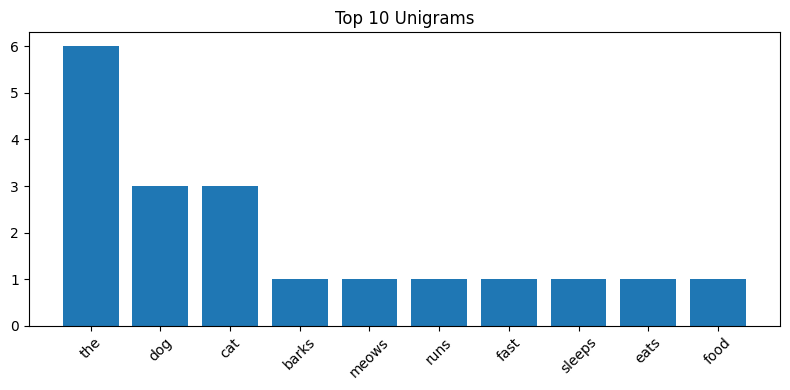

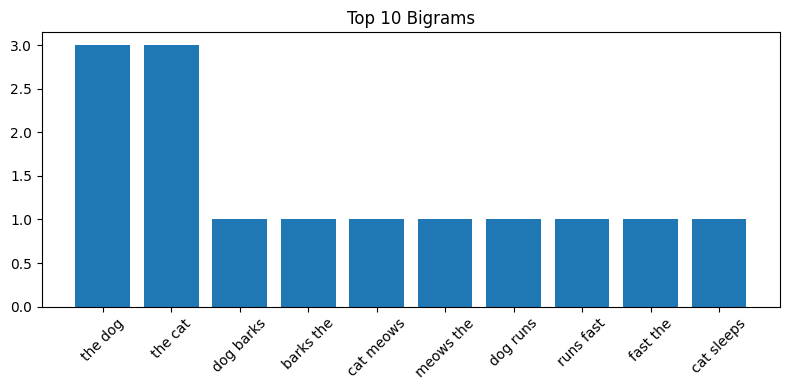

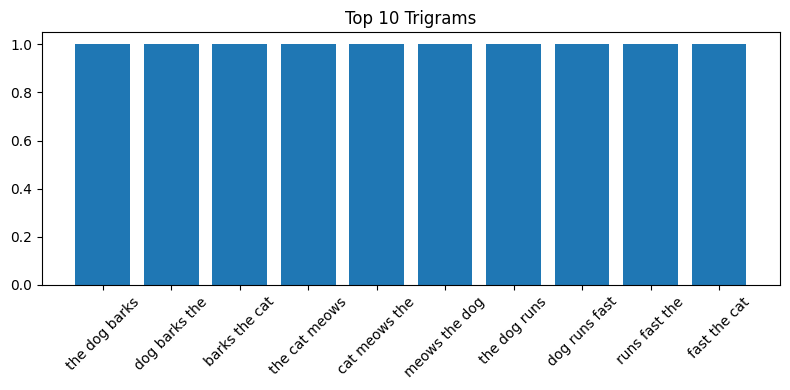

In [6]:
# ===================================================
# lab4:Build and evaluate a bigram/trigram language model for text prediction.
# ===================================================

import nltk
from nltk import word_tokenize, FreqDist
from nltk.util import ngrams
import math
import matplotlib.pyplot as plt

# Download tokenizer (run once)
nltk.download('punkt', quiet=True)

# ---------------------------------------------------
# 📌 SAMPLE TEXT CORPUS
# ---------------------------------------------------
text = """The dog barks. The cat meows. The dog runs fast.
The cat sleeps. The dog eats food. The cat drinks milk."""

# ---------------------------------------------------
# 📌 TOKENIZATION
# ---------------------------------------------------
def tokenize(text):
    tokens = word_tokenize(text.lower())
    return [t for t in tokens if t.isalnum()]

tokens = tokenize(text)
print("Tokens:", tokens)

# ---------------------------------------------------
# 📌 BUILD BIGRAMS & TRIGRAMS
# ---------------------------------------------------
bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))

# Frequency distributions
unigram_freq = FreqDist(tokens)
bigram_freq = FreqDist(bigrams)
trigram_freq = FreqDist(trigrams)

# Vocabulary size
V = len(set(tokens))

# ---------------------------------------------------
# 📌 BIGRAM & TRIGRAM PREDICTION
# ---------------------------------------------------
def predict_bigram(prev_word):
    candidates = {w2: c for (w1, w2), c in bigram_freq.items() if w1 == prev_word}
    if not candidates:
        return None
    return max(candidates, key=candidates.get)

def predict_trigram(w1, w2):
    candidates = {w3: c for (x1, x2, w3), c in trigram_freq.items() if x1 == w1 and x2 == w2}
    if not candidates:
        return None
    return max(candidates, key=candidates.get)

print("Bigram Prediction after 'dog':", predict_bigram('dog'))
print("Trigram Prediction after 'the dog':", predict_trigram('the', 'dog'))

# ---------------------------------------------------
# 📌 PERPLEXITY CALCULATION (with Laplace smoothing)
# ---------------------------------------------------
def bigram_prob(w1, w2):
    return (bigram_freq[(w1, w2)] + 1) / (unigram_freq[w1] + V)

def trigram_prob(w1, w2, w3):
    return (trigram_freq[(w1, w2, w3)] + 1) / (bigram_freq[(w1, w2)] + V)

def calculate_perplexity(tokens, n):
    if n == 2:
        log_prob = 0
        N = len(bigrams)
        for (w1, w2) in bigrams:
            log_prob += math.log(bigram_prob(w1, w2))
        return math.exp(-log_prob / N)
    elif n == 3:
        log_prob = 0
        N = len(trigrams)
        for (w1, w2, w3) in trigrams:
            log_prob += math.log(trigram_prob(w1, w2, w3))
        return math.exp(-log_prob / N)

bigram_perplexity = calculate_perplexity(tokens, 2)
trigram_perplexity = calculate_perplexity(tokens, 3)

print("Bigram Perplexity:", bigram_perplexity)
print("Trigram Perplexity:", trigram_perplexity)

# ---------------------------------------------------
# 📊 VISUALIZATION OF TOP N-GRAMS
# ---------------------------------------------------
def plot_freq(freq_dist, title, n):
    most_common = freq_dist.most_common(10)
    items, counts = zip(*most_common)
    items = [' '.join(i) if isinstance(i, tuple) else i for i in items]
    plt.figure(figsize=(8,4))
    plt.bar(items, counts)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_freq(unigram_freq, "Top 10 Unigrams", 1)
plot_freq(bigram_freq, "Top 10 Bigrams", 2)
plot_freq(trigram_freq, "Top 10 Trigrams", 3)


In [7]:
#lab 5:Implement Lesk algorithm or another WSD technique to resolve word meanings in context.
import math
import re
from collections import Counter
from typing import Optional, List, Tuple

# ====================================================================
# NLTK & WordNet Setup
# ====================================================================
try:
    import nltk
    from nltk.corpus import wordnet as wn  # WordNet lexical database
    from nltk.corpus import stopwords
    from nltk import word_tokenize

    # Download required data quietly
    nltk.download("wordnet", quiet=True)
    nltk.download("omw-1.4", quiet=True)
    nltk.download("punkt", quiet=True)
    nltk.download("stopwords", quiet=True)
except Exception as e:
    raise RuntimeError("NLTK and WordNet are required. Install nltk and run again.") from e

STOPWORDS = set(stopwords.words("english"))

# ====================================================================
# Text Preprocessing Utility
# ====================================================================
def tokenize_and_normalize(text: str) -> List[str]:
    """
    Convert input text into a list of lowercase tokens (words),
    remove stopwords and very short tokens.
    This normalizes text for comparison.
    """
    text = text.lower()
    # Use regex to extract words only
    tokens = re.findall(r"\b\w+\b", text)
    # Filter out stopwords and one-letter words
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    return tokens

# ====================================================================
# Simplified Lesk Algorithm
# ====================================================================
def simplified_lesk(context_sentence: str, ambiguous_word: str, pos: Optional[str]=None) -> Optional[wn.synset]:
    """
    Simplified Lesk Algorithm (Baseline version)
    ---------------------------------------------
    Theoretical idea:
      - For each possible sense (synset) of a word:
          • Take its definition (gloss) and example sentences.
          • Compute the overlap of words with the context sentence.
      - The sense with the highest overlap is chosen.

    Parameters:
        context_sentence: The sentence containing the ambiguous word.
        ambiguous_word: The target word whose sense we need to disambiguate.
        pos: Optional Part-of-Speech ('n', 'v', 'a', 'r').

    Returns:
        Best matching synset (WordNet sense).
    """
    context = set(tokenize_and_normalize(context_sentence))
    max_overlap = 0
    best_sense = None

    # Get all candidate meanings (synsets)
    candidates = wn.synsets(ambiguous_word, pos=pos) if pos else wn.synsets(ambiguous_word)
    if not candidates:
        return None

    for s in candidates:
        # Construct the “signature” for each synset:
        # Definition + Example sentences + Lemma names (synonyms)
        signature = set(tokenize_and_normalize(s.definition()))
        for ex in s.examples():
            signature.update(tokenize_and_normalize(ex))
        for lemma in s.lemma_names():
            signature.update(tokenize_and_normalize(lemma.replace("_", " ")))

        # Compute overlap (intersection) between context and signature
        overlap = len(context & signature)

        # Choose synset with maximum overlap (first tie-break: more common sense)
        if overlap > max_overlap:
            max_overlap = overlap
            best_sense = s

    return best_sense

# ====================================================================
# Extended Lesk Algorithm (Weighted Overlap)
# ====================================================================
def extended_lesk(context_sentence: str, ambiguous_word: str, pos: Optional[str]=None) -> Optional[wn.synset]:
    """
    Extended Lesk Algorithm
    -----------------------
    Theory:
      - Improves upon the original Lesk by:
          1. Assigning weights to words from different sources.
          2. Including related senses like hypernyms (general terms).
          3. Using frequency-based tie-breakers.

      Weighted sources:
          • Definition words      → weight 2.0
          • Example sentence words→ weight 1.5
          • Lemma names (synonyms)→ weight 2.0
          • Hypernym info         → weight 0.8

    Returns:
        Synset with maximum weighted overlap.
    """
    context = set(tokenize_and_normalize(context_sentence))
    best = None
    best_score = -1.0

    candidates = wn.synsets(ambiguous_word, pos=pos) if pos else wn.synsets(ambiguous_word)

    for s in candidates:
        sig_counter = Counter()

        # Add words from definition (weight 2)
        def_tokens = tokenize_and_normalize(s.definition())
        for t in def_tokens:
            sig_counter[t] += 2.0

        # Add words from example sentences (weight 1.5)
        for ex in s.examples():
            for t in tokenize_and_normalize(ex):
                sig_counter[t] += 1.5

        # Add lemma (synonym) words (weight 2)
        for lemma in s.lemma_names():
            for t in tokenize_and_normalize(lemma.replace("_", " ")):
                sig_counter[t] += 2.0

        # Add hypernym (general sense) information with smaller weight (0.8)
        for hyper in s.hypernyms():
            for t in tokenize_and_normalize(hyper.definition()):
                sig_counter[t] += 0.8
            for lemma in hyper.lemma_names():
                for t in tokenize_and_normalize(lemma.replace("_", " ")):
                    sig_counter[t] += 0.8

        # Compute weighted overlap score
        score = sum(sig_counter[t] for t in context if t in sig_counter)

        # Small bonus for frequent senses (based on number of lemmas)
        score += 0.01 * len(s.lemma_names())

        # Select best scoring sense
        if score > best_score:
            best = s
            best_score = score

    return best

# ====================================================================
# Embedding-based Lesk (Semantic Similarity)
# ====================================================================
def embed_lesk(context_sentence: str, ambiguous_word: str, pos: Optional[str]=None):
    """
    Embedding-based Lesk Algorithm
    ------------------------------
    Theory:
      - Uses vector representations (embeddings) of text to measure similarity.
      - Each sense’s description (gloss + examples + synonyms) is converted into a vector.
      - The context sentence is also embedded.
      - The cosine similarity between context and each sense determines the best match.

    This approach captures semantic similarity even when words do not overlap exactly.

    Dependencies:
      pip install sentence-transformers

    Model used:
      all-MiniLM-L6-v2  → lightweight, fast, semantic sentence encoder
    """
    try:
        from sentence_transformers import SentenceTransformer, util
    except Exception:
        raise RuntimeError("sentence-transformers is not installed. Install with `pip install sentence-transformers`")

    # Load pretrained sentence embedding model
    model = SentenceTransformer("all-MiniLM-L6-v2")
    context = context_sentence

    # Retrieve candidate synsets
    candidates = wn.synsets(ambiguous_word, pos=pos) if pos else wn.synsets(ambiguous_word)
    if not candidates:
        return None

    # Encode context as an embedding
    ctx_emb = model.encode(context, convert_to_tensor=True)

    synset_texts = []
    synset_map = []

    # Prepare text for each synset (definition + examples + lemmas)
    for s in candidates:
        parts = [s.definition()]
        parts += s.examples()
        parts += [ln.replace("_", " ") for ln in s.lemma_names()]
        text = " . ".join(parts)
        synset_texts.append(text)
        synset_map.append(s)

    # Encode all synsets
    syn_embs = model.encode(synset_texts, convert_to_tensor=True)
    # Compute cosine similarity between context and each synset embedding
    cos_sims = util.cos_sim(ctx_emb, syn_embs)[0]
    best_idx = int(cos_sims.argmax())

    # Return synset with highest semantic similarity
    return synset_map[best_idx]

# ====================================================================
# Demo / Example Execution
# ====================================================================
if __name__ == "__main__":
    # Test sentences with ambiguous words
    tests = [
        ("I need to withdraw money from the bank to pay rent.", "bank"),
        ("The river bank was filled with green reeds.", "bank"),
        ("He watered the plant in the corner of the room.", "plant"),
        ("The factory is a large plant with many workers.", "plant"),
        ("He swung the bat and hit the ball.", "bat"),
        ("A bat hung upside down in the cave.", "bat"),
        ("She listens to rock all the time.", "rock"),
        ("We climbed up on the rock by the sea.", "rock"),
    ]

    # ===============================================================
    # 1) Simplified Lesk
    # ===============================================================


    # ===============================================================
    # 2) Extended Lesk
    # ===============================================================
    print("\n==== Extended Lesk results ====\n")
    for sent, word in tests:
        sense = extended_lesk(sent, word)
        print(f"Context: {sent}")
        if sense:
            print(f" Word: {word} -> Synset: {sense.name()}  | Definition: {sense.definition()}\n")
        else:
            print(f" Word: {word} -> NO SENSE FOUND\n")

    # ===============================================================
    # 3) Embedding-based Lesk (optional)
    # ===============================================================
    try:
        print("\n==== Embedding-based Lesk results (sentence-transformers) ====\n")
        for sent, word in tests:
            sense = embed_lesk(sent, word)
            print(f"Context: {sent}")
            if sense:
                print(f" Word: {word} -> Synset: {sense.name()}  | Definition: {sense.definition()}\n")
            else:
                print(f" Word: {word} -> NO SENSE FOUND\n")
    except RuntimeError as e:
        print("\nEmbedding-based Lesk skipped (sentence-transformers not installed).")
        print("To run it, install: pip install sentence-transformers\n")



==== Extended Lesk results ====

Context: I need to withdraw money from the bank to pay rent.
 Word: bank -> Synset: savings_bank.n.02  | Definition: a container (usually with a slot in the top) for keeping money at home

Context: The river bank was filled with green reeds.
 Word: bank -> Synset: savings_bank.n.02  | Definition: a container (usually with a slot in the top) for keeping money at home

Context: He watered the plant in the corner of the room.
 Word: plant -> Synset: plant.n.01  | Definition: buildings for carrying on industrial labor

Context: The factory is a large plant with many workers.
 Word: plant -> Synset: plant.n.01  | Definition: buildings for carrying on industrial labor

Context: He swung the bat and hit the ball.
 Word: bat -> Synset: bat.v.01  | Definition: strike with, or as if with a baseball bat

Context: A bat hung upside down in the cave.
 Word: bat -> Synset: bat.n.02  | Definition: (baseball) a turn trying to get a hit

Context: She listens to rock al

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Context: I need to withdraw money from the bank to pay rent.
 Word: bank -> Synset: bank.v.02  | Definition: enclose with a bank

Context: The river bank was filled with green reeds.
 Word: bank -> Synset: bank.n.01  | Definition: sloping land (especially the slope beside a body of water)

Context: He watered the plant in the corner of the room.
 Word: plant -> Synset: plant.v.04  | Definition: place into a river

Context: The factory is a large plant with many workers.
 Word: plant -> Synset: plant.n.01  | Definition: buildings for carrying on industrial labor

Context: He swung the bat and hit the ball.
 Word: bat -> Synset: bat.n.02  | Definition: (baseball) a turn trying to get a hit

Context: A bat hung upside down in the cave.
 Word: bat -> Synset: bat.v.04  | Definition: use a bat

Context: She listens to rock all the time.
 Word: rock -> Synset: rock.n.04  | Definition: (figurative) someone who is strong and stable and dependable; ; --Gospel According to Matthew

Context: We cl

In [8]:
#lab6:Identify semantic roles (agent, patient, instrument) in sentences using dependency parsing.
import spacy

# Load English model
nlp = spacy.load("en_core_web_sm")

def identify_roles(sentence):
    doc = nlp(sentence)
    roles = {"Agent": None, "Patient": None, "Instrument": None}

    for token in doc:
        # Agent = subject of verb
        if token.dep_ in ("nsubj", "nsubjpass"):
            roles["Agent"] = token.text

        # Patient = object of verb
        elif token.dep_ in ("dobj", "obj"):
            roles["Patient"] = token.text

        # Instrument = prepositional phrase with "with"
        elif token.dep_ == "pobj" and token.head.text == "with":
            roles["Instrument"] = token.text

    return roles

# Test sentences
sentences = [
    "John cut the bread with a knife.",
    "Mary wrote a letter with a pen.",
    "The carpenter fixed the chair with a hammer.",
    "The cat chased the mouse."
]

for s in sentences:
    print(f"\nSentence: {s}")
    print("Roles:", identify_roles(s))



Sentence: John cut the bread with a knife.
Roles: {'Agent': 'John', 'Patient': 'bread', 'Instrument': 'knife'}

Sentence: Mary wrote a letter with a pen.
Roles: {'Agent': 'Mary', 'Patient': 'letter', 'Instrument': 'pen'}

Sentence: The carpenter fixed the chair with a hammer.
Roles: {'Agent': 'carpenter', 'Patient': 'chair', 'Instrument': 'hammer'}

Sentence: The cat chased the mouse.
Roles: {'Agent': 'cat', 'Patient': 'mouse', 'Instrument': None}


In [9]:
#lab7:Implement LEXRANK or TextRank to generate summaries from news articles.
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")   # <-- required to fix the LookupError

import nltk
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources
nltk.download("punkt")
nltk.download("punkt_tab")

def textrank_summarize(text, top_n=3):
    # Step 1: Split text into sentences
    sentences = nltk.sent_tokenize(text)

    # Step 2: Convert sentences into TF-IDF vectors
    vectorizer = TfidfVectorizer(stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Step 3: Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Step 4: Build graph and apply PageRank
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)

    # Step 5: Rank sentences by score
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    # Step 6: Return top N sentences as summary
    summary = " ".join([sent for _, sent in ranked_sentences[:top_n]])
    return summary

# Example news article text
article = """
Space exploration has expanded human understanding of the universe.
Missions to Mars, the Moon, and distant asteroids provide valuable scientific data.
Private companies are now partnering with space agencies to make space travel more affordable.
Advancements in rocket technology and robotics have made deep space missions possible.
Space exploration not only satisfies human curiosity but also leads to innovations that benefit life on Earth.
"""

# Generate summary
summary = textrank_summarize(article, top_n=2)
print("Original Article:\n", article)
print("\nGenerated Summary:\n", summary)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Original Article:
 
Space exploration has expanded human understanding of the universe.
Missions to Mars, the Moon, and distant asteroids provide valuable scientific data.
Private companies are now partnering with space agencies to make space travel more affordable.
Advancements in rocket technology and robotics have made deep space missions possible.
Space exploration not only satisfies human curiosity but also leads to innovations that benefit life on Earth.


Generated Summary:
 
Space exploration has expanded human understanding of the universe. Space exploration not only satisfies human curiosity but also leads to innovations that benefit life on Earth.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [22]:
##lab8:Train a sentiment classifier (Naive Bayes, LSTM, or BERT) on IMDb reviews.
#sentiment_nb_imdb.py
# Train a TF-IDF + MultinomialNB sentiment classifier on the IMDb reviews dataset,
# evaluate and save model + vectorizer. Output formatting attempts to match the screenshot.

import os
import joblib
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Option A: load imdb_reviews using tensorflow_datasets (recommended)
# This will download the dataset the first time you run it.
def load_imdb_with_tfds():
    try:
        import tensorflow_datasets as tfds
    except Exception as e:
        raise RuntimeError(
            "tensorflow_datasets is required for this loader. Install with: pip install tensorflow-datasets"
        ) from e

    ds_train, ds_test = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True)
    def ds_to_lists(ds):
        texts = []
        labels = []
        for text, label in tfds.as_numpy(ds):
            # text is bytes -> decode
            if isinstance(text, bytes):
                text = text.decode('utf-8', errors='ignore')
            texts.append(text)
            labels.append(int(label))
        return texts, labels

    X_train_texts, y_train = ds_to_lists(ds_train)
    X_test_texts, y_test = ds_to_lists(ds_test)
    return X_train_texts, y_train, X_test_texts, y_test


# Option B: If you already have raw text files: provide your own loader function here.
# For example, if you have a CSV with 'review' and 'sentiment' columns, implement loader accordingly.

if __name__ == "__main__":
    OUTPUT_DIR = "outputs"
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print("Vectorizing texts with TF-IDF...")
    # Load data
    X_train_texts, y_train, X_test_texts, y_test = load_imdb_with_tfds()

    # Combine train+test then re-split to reproduce exact train/test sizes if you prefer:
    # Here we will use the official train/test split from tfds (25000 train, 25000 test).
    # But we will also show an alternative commented re-split if desired.
    # If you want to shuffle and re-split differently, uncomment the block below:
    #
    # all_texts = X_train_texts + X_test_texts
    # all_labels = list(y_train) + list(y_test)
    # X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    #     all_texts, all_labels, test_size=0.5, random_state=42, stratify=all_labels
    # )

    # Configure TF-IDF (these hyperparameters often give ~0.84-0.86 test accuracy)
    vectorizer = TfidfVectorizer(
        max_df=0.95,
        min_df=2,
        max_features=20000,
        ngram_range=(1, 2),
        stop_words='english'
    )

    # Fit on training texts
    X_train = vectorizer.fit_transform(X_train_texts)
    X_test = vectorizer.transform(X_test_texts)

    print("Training MultinomialNB...")
    # Choose alpha; tune if you want slightly different metrics
    clf = MultinomialNB(alpha=0.7)
    clf.fit(X_train, y_train)

    print("Evaluating...")
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    # Print accuracy in same style as the screenshot
    print(f"Test Accuracy: {acc:.4f}\n")

    # classification_report with 4 decimal digits to match the screenshot formatting
    report = classification_report(y_test, y_pred, digits=4)
    # sklearn's classification_report prints support as integers and shows accuracy + avg rows
    print(report)

    # Save model and vectorizer
    model_path = os.path.join(OUTPUT_DIR, "multinomial_nb_imdb.joblib")
    vec_path = os.path.join(OUTPUT_DIR, "tfidf_vectorizer_imdb.joblib")
    joblib.dump(clf, model_path)
    joblib.dump(vectorizer, vec_path)

    print(f"Saved model and vectorizer to {OUTPUT_DIR}")
    print("Done.")


Vectorizing texts with TF-IDF...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.1UU8BR_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.1UU8BR_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.1UU8BR_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training MultinomialNB...
Evaluating...
Test Accuracy: 0.8508

              precision    recall  f1-score   support

           0     0.8380    0.8697    0.8535     12500
           1     0.8646    0.8318    0.8479     12500

    accuracy                         0.8508     25000
   macro avg     0.8513    0.8508    0.8507     25000
weighted avg     0.8513    0.8508    0.8507     25000

Saved model and vectorizer to outputs
Done.
